# Requerimiento 4: Clustering Jerárquico de Artículos

## Descripción del Requerimiento

Este notebook implementa **clustering jerárquico aglomerativo** para agrupar artículos científicos según la similitud de sus abstracts.

### Objetivos:
1. Cargar y procesar abstracts de artículos desde archivo BibTeX
2. Limpiar y preprocesar texto eliminando stopwords y caracteres especiales
3. Vectorizar usando TF-IDF para representación numérica
4. Aplicar clustering jerárquico con diferentes métodos de enlace
5. Visualizar resultados mediante dendrogramas

### Algoritmos Implementados:
- **Single Linkage**: Distancia mínima entre clusters
- **Complete Linkage**: Distancia máxima entre clusters
- **Average Linkage**: Distancia promedio entre clusters

### Importaciones

### Librerías Importadas

Esta celda carga todas las dependencias necesarias para el análisis:

**Procesamiento de Datos**:
- **bibtexparser**: Parsea archivos `.bib` y extrae metadatos bibliográficos
- **re**: Expresiones regulares para limpieza de texto

**Procesamiento de Lenguaje Natural**:
- **nltk**: Natural Language Toolkit para procesamiento de texto
- **stopwords**: Lista de palabras comunes sin valor semántico

**Machine Learning**:
- **TfidfVectorizer**: Convierte texto a vectores numéricos usando TF-IDF
  - **TF** (Term Frequency): Frecuencia de término en documento
  - **IDF** (Inverse Document Frequency): Importancia del término en el corpus

**Clustering y Distancias**:
- **pdist**: Calcula matriz de distancias entre todos los pares de documentos
- **linkage**: Implementa algoritmos de clustering jerárquico
- **dendrogram**: Genera visualización del árbol jerárquico

**Utilidades**:
- **numpy**: Operaciones matriciales y manejo de arrays
- **matplotlib**: Generación de gráficos y dendrogramas

In [2]:
# Importamos las librerías necesarias
import bibtexparser     # Permite leer y procesar archivos .bib (formato bibliográfico de referencias)
import re                   # Librería estándar para trabajar con expresiones regulares (búsqueda y reemplazo de patrones de texto)
import nltk                 # Natural Language Toolkit: herramienta para procesamiento de lenguaje natural
from nltk.corpus import stopwords  # Módulo para acceder a las palabras vacías ("stopwords")

# Esta herramienta convierte texto en vectores numéricos usando el modelo
# TF-IDF (Term Frequency – Inverse Document Frequency),
# que mide la relevancia de cada palabra en relación con todos los documentos.
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.spatial.distance import pdist        # Calcula las distancias entre cada par de documentos
from scipy.cluster.hierarchy import linkage, dendrogram  # Realiza el agrupamiento jerárquico y genera el dendrograma
import numpy as np                              # Para manejo de matrices y operaciones numéricas
import matplotlib.pyplot as plt                 # Para graficar los dendrogramas

### Carga y Extracción de Abstracts

### Carga de Datos desde BibTeX

Esta celda realiza la extracción de abstracts y títulos del archivo consolidado.

#### Proceso de Carga:

**1. Configuración de Variables de Entorno**
```python
from dotenv import load_dotenv
ruta_bib = os.getenv("CONSOLIDADO_PATH", "../consolidado.bib")
```
- Carga ruta desde archivo `.env`
- Fallback a ruta relativa si no existe la variable

**2. Parsing con bibtexparser**
```python
bib_database = bibtexparser.load(bibtex_file)
```
- Convierte el archivo a estructura de datos Python
- Cada entrada es un diccionario con campos bibliográficos

**3. Extracción de campos**
- **abstract**: Resumen del artículo (texto principal para análisis)
- **title**: Título del artículo (para etiquetas en dendrograma)

**4. Muestreo de datos**
```python
abstracts_muestra = abstracts[:100]
```
- Se toman solo 100 artículos para visualización clara
- Con miles de artículos el dendrograma sería ilegible

#### Consideraciones sobre Tamaño de Muestra:

**Tamaño vs Legibilidad**:
- **100 artículos**: Dendrograma legible, análisis rápido
- **500+ artículos**: Dendrograma denso, análisis lento
- **1000+ artículos**: Dendrograma ilegible

**Alternativa de Muestreo Aleatorio**:
```python
import random
indices = random.sample(range(len(abstracts)), 100)
abstracts_muestra = [abstracts[i] for i in indices]
```

In [3]:
import os
from dotenv import load_dotenv

# Cargar variables de entorno
load_dotenv()

# Obtener ruta del archivo consolidado desde variable de entorno
ruta_bib = os.getenv("CONSOLIDADO_PATH", "../consolidado.bib")

# Verificar que el archivo existe
if not os.path.exists(ruta_bib):
    print(f"Error: No se encuentra el archivo en {ruta_bib}")
    raise FileNotFoundError(f"No se encuentra {ruta_bib}")

print(f"Leyendo archivo: {ruta_bib}")

# Se abre el archivo con codificación UTF-8 (para evitar errores de caracteres especiales)
# y se carga usando bibtexparser, que convierte el contenido en una estructura tipo diccionario.
with open(ruta_bib, encoding="utf-8") as bibtex_file:
    bib_database = bibtexparser.load(bibtex_file)

# Recorremos todas las entradas del archivo .bib
# y extraemos los campos "abstract" (resumen) y "title" (título).
abstracts = []
titulos = []
for entry in bib_database.entries:
    # Verificamos que la entrada tenga un resumen
    if "abstract" in entry:
        abstracts.append(entry["abstract"])                     # Guardamos el resumen
        titulos.append(entry.get("title", "Sin título"))        # Guardamos el título (o "Sin título" si no existe)

# Mostramos cuántos abstracts se encontraron en total
print(f"Total de abstracts encontrados: {len(abstracts)}")

# Para evitar problemas de rendimiento ya que el archivo tiene más de 10000 abstracts,
# se toma solo una muestra de los primeros 100 abstracts (para que se vea más bonito los dendogramas).
# Esto permite analizar un subconjunto representativo sin saturar la memoria.

if len(abstracts) > 100:
    abstracts_muestra = abstracts[:100]     # Toma los primeros 100 abstracts
    titulos_muestra = titulos[:100]         # Toma los títulos correspondientes
else:
    abstracts_muestra = abstracts           # Si hay menos de 100, usa todos
    titulos_muestra = titulos

# Mostramos cuántos abstracts se analizarán finalmente
print(f"Se analizarán los primeros {len(abstracts_muestra)} abstracts del archivo.")

Leyendo archivo: C:\Users\DIEGO\Documents\GitHub\proyectoAnalisisAlgoritmos\proyecto\consolidado.bib
Total de abstracts encontrados: 9443
Se analizarán los primeros 100 abstracts del archivo.


### Preprocesamiento de Texto

### Limpieza y Normalización de Texto

Esta celda prepara los abstracts para el análisis de clustering mediante limpieza y normalización.

#### Proceso de Preprocesamiento:

**1. Conversión a Minúsculas**
```python
texto = texto.lower()
```
- Normaliza el texto para que "Machine" y "machine" sean tratados igual

**2. Eliminación de Caracteres Especiales**
```python
texto = re.sub(r'[^a-z\s]', '', texto)
```
- Mantiene solo letras y espacios
- Elimina números, puntuación y símbolos

**3. Eliminación de Stopwords**
```python
palabras = [p for p in palabras if p not in stop_words]
```
- Remueve palabras comunes sin valor semántico (the, is, at, etc.)
- Reduce dimensionalidad y ruido en el análisis

**4. Reconstrucción del Texto**
```python
return ' '.join(palabras)
```
- Une las palabras filtradas en un string limpio

#### Importancia del Preprocesamiento:

**Sin Preprocesamiento**:
- "Machine Learning" y "machine-learning" serían términos diferentes
- Stopwords dominarían las frecuencias
- Puntuación generaría tokens inválidos

**Con Preprocesamiento**:
- Texto normalizado y consistente
- Enfoque en palabras con significado semántico
- Vectorización más efectiva

In [4]:
# Las stopwords son palabras muy comunes como "the", "and", "is", etc.
# que no aportan significado útil al análisis y se eliminan.
nltk.download('stopwords')

# Se obtiene el conjunto de palabras vacías en inglés
stop_words = set(stopwords.words("english"))


def limpiar_texto(texto):
    """
    Esta función limpia el texto de cada abstract para dejarlo listo
    para el análisis de similitud. Realiza varios pasos:
      1. Convierte el texto a minúsculas.
      2. Elimina todos los caracteres que no sean letras (como números o signos de puntuación).
      3. Separa las palabras (tokeniza de forma simple con split()).
      4. Elimina las stopwords y las palabras muy cortas (menores de 3 letras).
      5. Une las palabras limpias nuevamente en un solo texto.
    """
    #Convertir todo el texto a minúsculas
    texto = texto.lower()

    #Eliminar caracteres que no sean letras (mantiene solo a-z y espacios)
    texto = re.sub(r'[^a-z\s]', '', texto)

    #Dividir el texto en palabras individuales
    palabras = texto.split()

    #Eliminar stopwords y palabras muy cortas
    palabras = [w for w in palabras if w not in stop_words and len(w) > 2]

    #Volver a unir las palabras en un texto limpio
    return " ".join(palabras)

# Se recorre la lista de abstracts seleccionados (los primeros 100)
# y se aplica la función "limpiar_texto" a cada uno.
abstracts_limpios = [limpiar_texto(a) for a in abstracts_muestra]

# Se imprime un ejemplo de texto ya limpio (solo los primeros 300 caracteres)
print("Ejemplo de texto limpio:\n")
print(abstracts_limpios[0][:300])


Ejemplo de texto limpio:

programming typically involves humans formulating instructions computer execute computations adhere definition machine would seemingly lack capability autonomously design algorithms however recent generative artificial intelligence models gpt demonstrated impressive ability perform complex human tas


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DIEGO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Vectorización TF-IDF

### Conversión de Texto a Vectores TF-IDF

Esta celda transforma los abstracts preprocesados en vectores numéricos usando TF-IDF.

#### Fundamento Matemático:

**TF-IDF (Term Frequency - Inverse Document Frequency)**:

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$$

Donde:
- **TF (Term Frequency)**: Frecuencia del término en el documento
  $$\text{TF}(t, d) = \frac{\text{count}(t, d)}{\text{total words in } d}$$

- **IDF (Inverse Document Frequency)**: Importancia del término en el corpus
  $$\text{IDF}(t) = \log\left(\frac{N}{\text{df}(t)}\right)$$
  - $N$: Total de documentos
  - $\text{df}(t)$: Número de documentos que contienen el término

**Intuición**:
- Palabras frecuentes en un documento pero raras en el corpus → **Alto TF-IDF** (relevantes)
- Palabras comunes en todos los documentos → **Bajo TF-IDF** (poco discriminativas)

#### Implementación con scikit-learn:

```python
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(abstracts_procesados)
```

**Parámetros**:
- `max_features=1000`: Limita a las 1000 palabras más relevantes
- `fit_transform()`: Aprende vocabulario y transforma documentos

**Salida**:
- Matriz dispersa de dimensiones `(n_documentos, n_features)`
- Cada fila es un documento representado como vector de pesos TF-IDF

#### Ventajas de TF-IDF:

- **Captura importancia relativa**: No solo frecuencia absoluta
- **Reduce ruido**: Palabras comunes tienen bajo peso
- **Eficiente**: Representación dispersa ahorra memoria
- **Estándar**: Ampliamente usado en NLP y clustering

In [5]:
# max_features = 1000 limita el número de palabras que se considerarán.
# Esto mejora el rendimiento y evita que la matriz sea demasiado grande.
# El vectorizador eliminará automáticamente las palabras muy poco frecuentes.
vectorizador = TfidfVectorizer(max_features=1000)

# El método fit_transform() realiza dos tareas:
#  1. Aprende el vocabulario y la importancia de cada palabra (fit)
#  2. Convierte cada abstract en un vector numérico (transform)
# Cada fila de la matriz resultante representa un abstract,
# y cada columna representa una palabra del vocabulario.
matriz_tfidf = vectorizador.fit_transform(abstracts_limpios)

# Se imprime la forma (filas, columnas) de la matriz:
# - Filas = cantidad de abstracts analizados
# - Columnas = cantidad de palabras consideradas (máximo 1000)
print(f"Matriz TF-IDF generada con forma: {matriz_tfidf.shape}")



Matriz TF-IDF generada con forma: (100, 1000)


### Clustering Jerárquico - Método de Enlace Simple (Single Linkage)

### Clustering Jerárquico con Enlace Simple

Esta celda implementa clustering jerárquico usando el método de enlace simple.

#### Fundamento Matemático:

**Enlace Simple (Single Linkage)**:

La distancia entre dos clusters $C_i$ y $C_j$ se define como:

$$d(C_i, C_j) = \min_{x \in C_i, y \in C_j} d(x, y)$$

Es decir, la distancia mínima entre cualquier par de puntos de los dos clusters.

**Algoritmo**:
1. Inicialmente, cada documento es un cluster
2. En cada iteración:
   - Encuentra el par de clusters con menor distancia
   - Fusiona ese par en un nuevo cluster
3. Repite hasta tener un solo cluster

**Características**:
- **Sensible a outliers**: Un solo punto puede unir clusters distantes
- **Efecto cadena**: Tiende a formar clusters alargados
- **Complejidad**: $O(n^2 \log n)$ con optimizaciones

#### Implementación:

```python
from scipy.cluster.hierarchy import linkage, dendrogram

Z_single = linkage(X.toarray(), method='single', metric='euclidean')
```

**Parámetros**:
- `method='single'`: Usa enlace simple
- `metric='euclidean'`: Distancia euclidiana entre vectores TF-IDF

**Salida**:
- Matriz de enlace `Z` de dimensiones `(n-1, 4)`:
  - Columna 0-1: Índices de clusters fusionados
  - Columna 2: Distancia de fusión
  - Columna 3: Número de elementos en el nuevo cluster

#### Visualización con Dendrograma:

```python
dendrogram(Z_single, truncate_mode='lastp', p=30)
```

El dendrograma muestra:
- **Eje Y**: Distancia de fusión
- **Eje X**: Documentos o clusters
- **Altura de fusión**: Similaridad entre clusters (menor = más similar)


Generando dendrograma con método: SINGLE...
Dendrograma guardado en: dendrograma_single.png


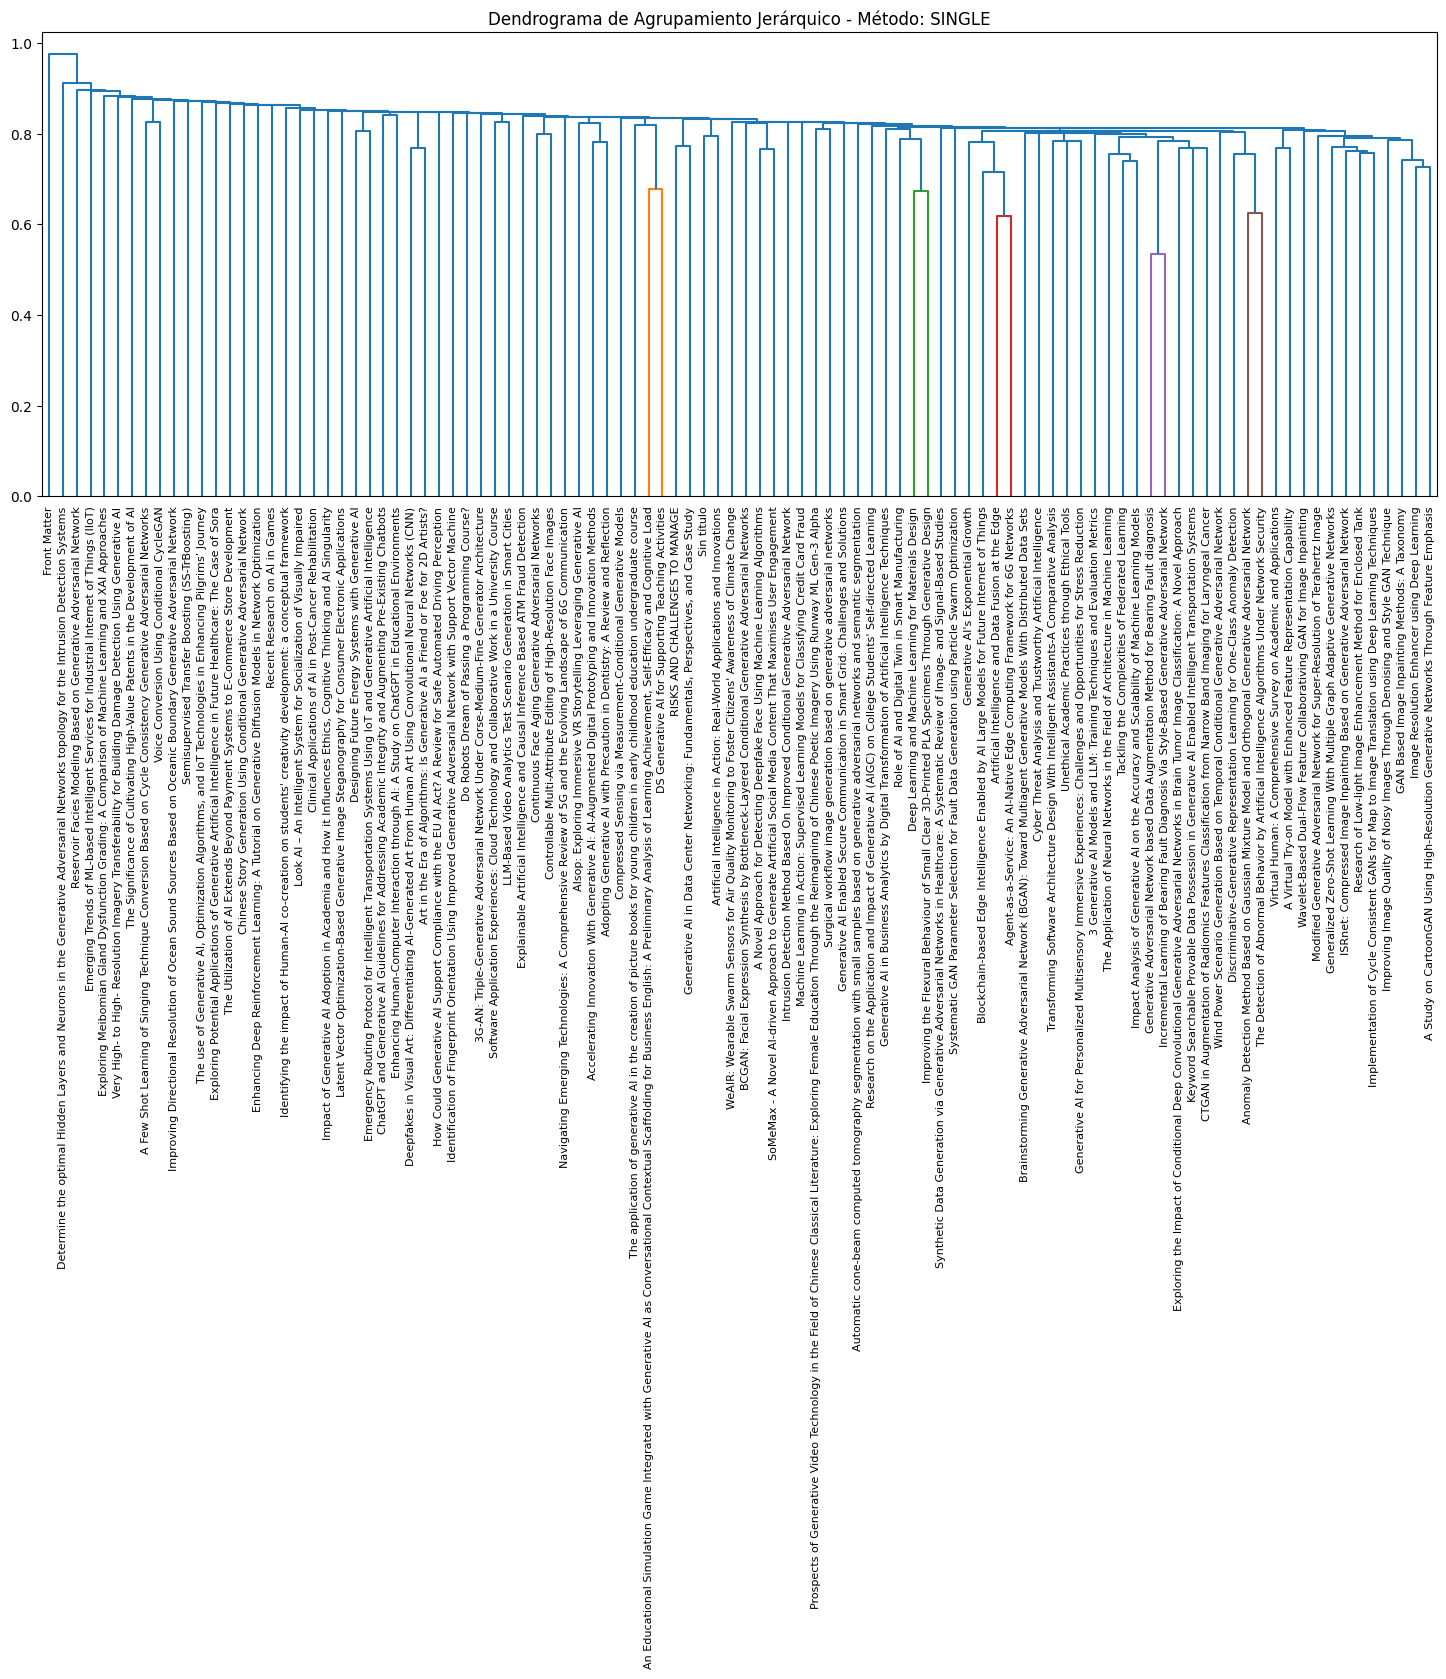


Generando dendrograma con método: COMPLETE...
Dendrograma guardado en: dendrograma_complete.png


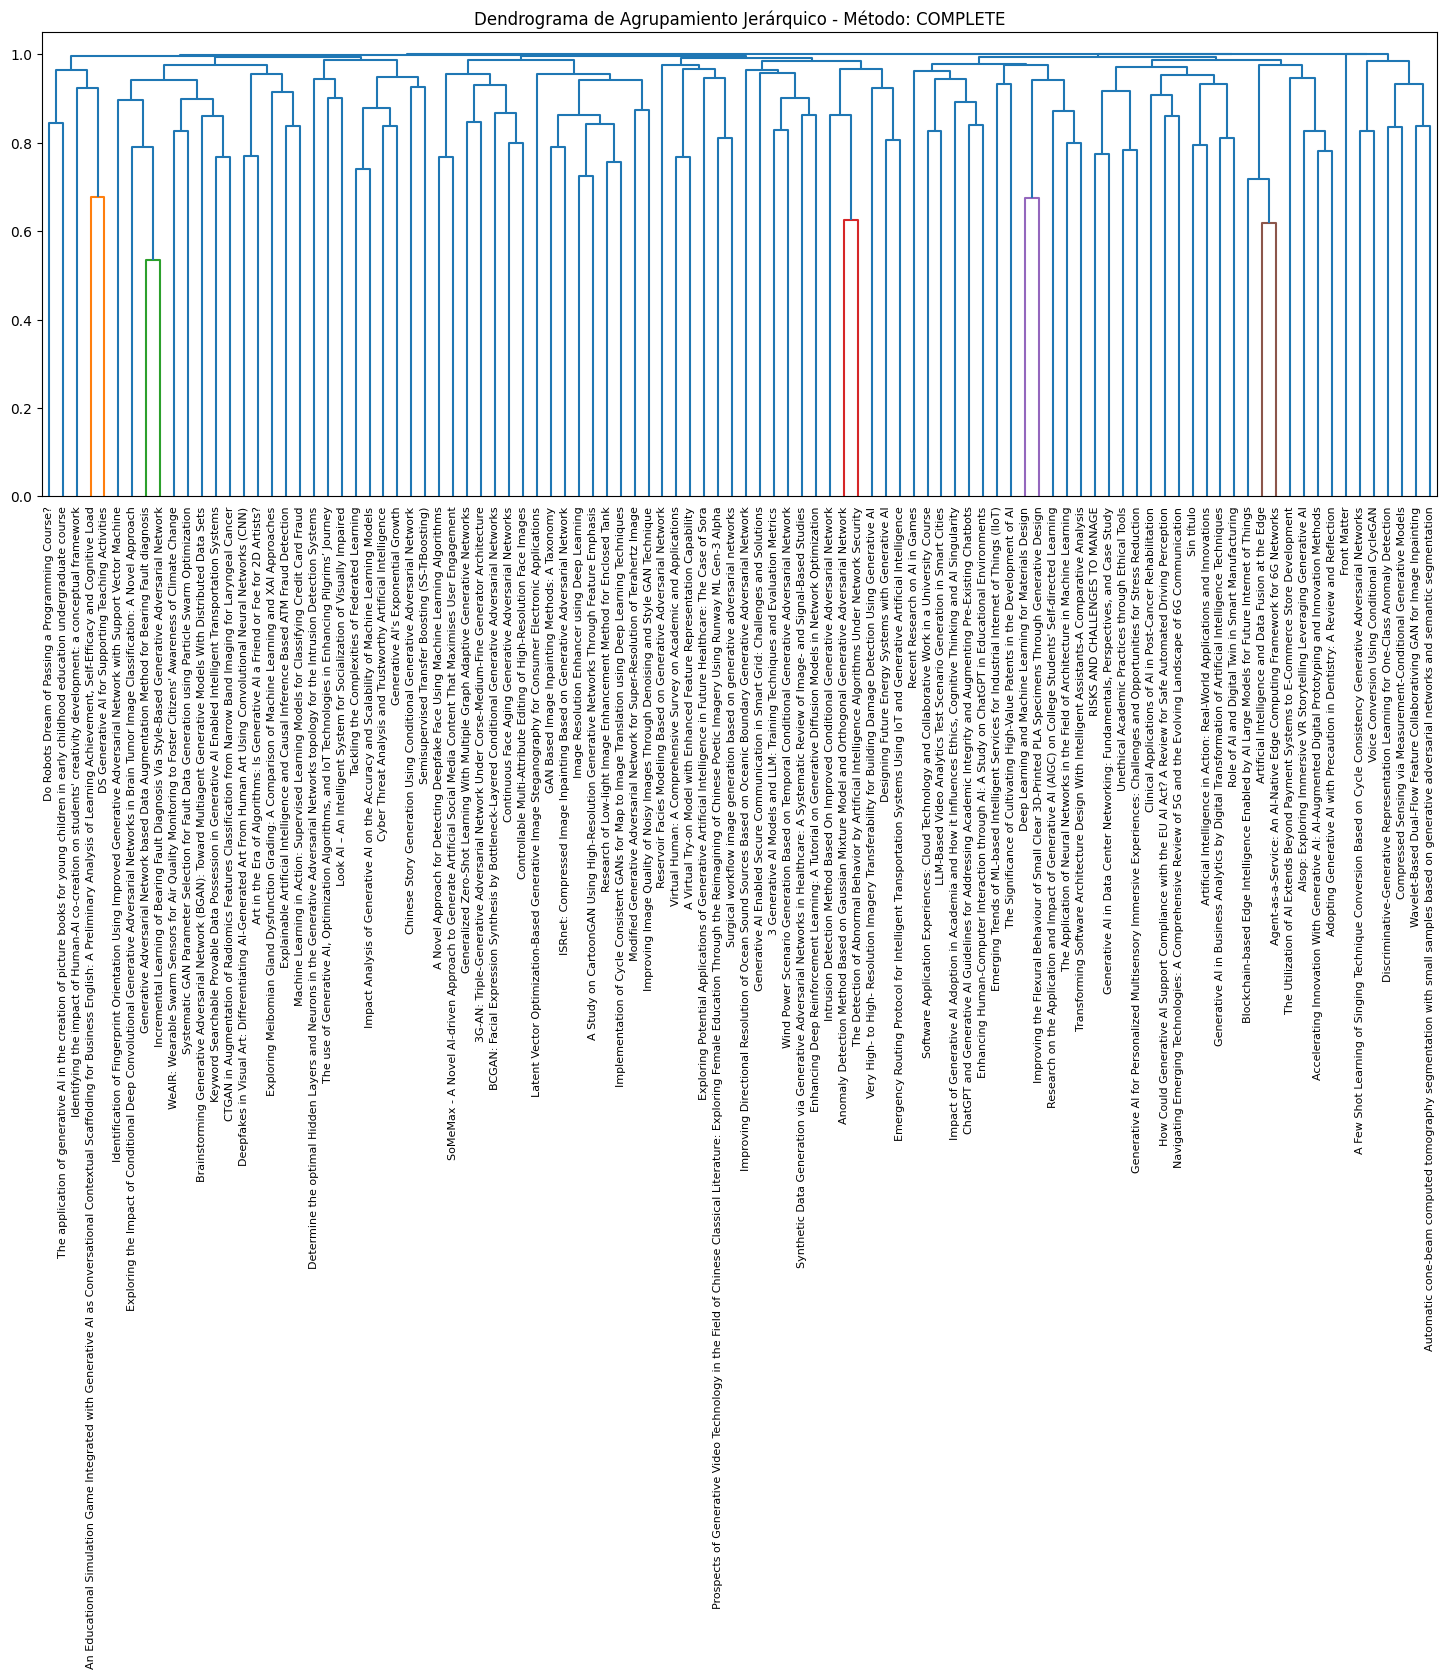


Generando dendrograma con método: AVERAGE...
Dendrograma guardado en: dendrograma_average.png


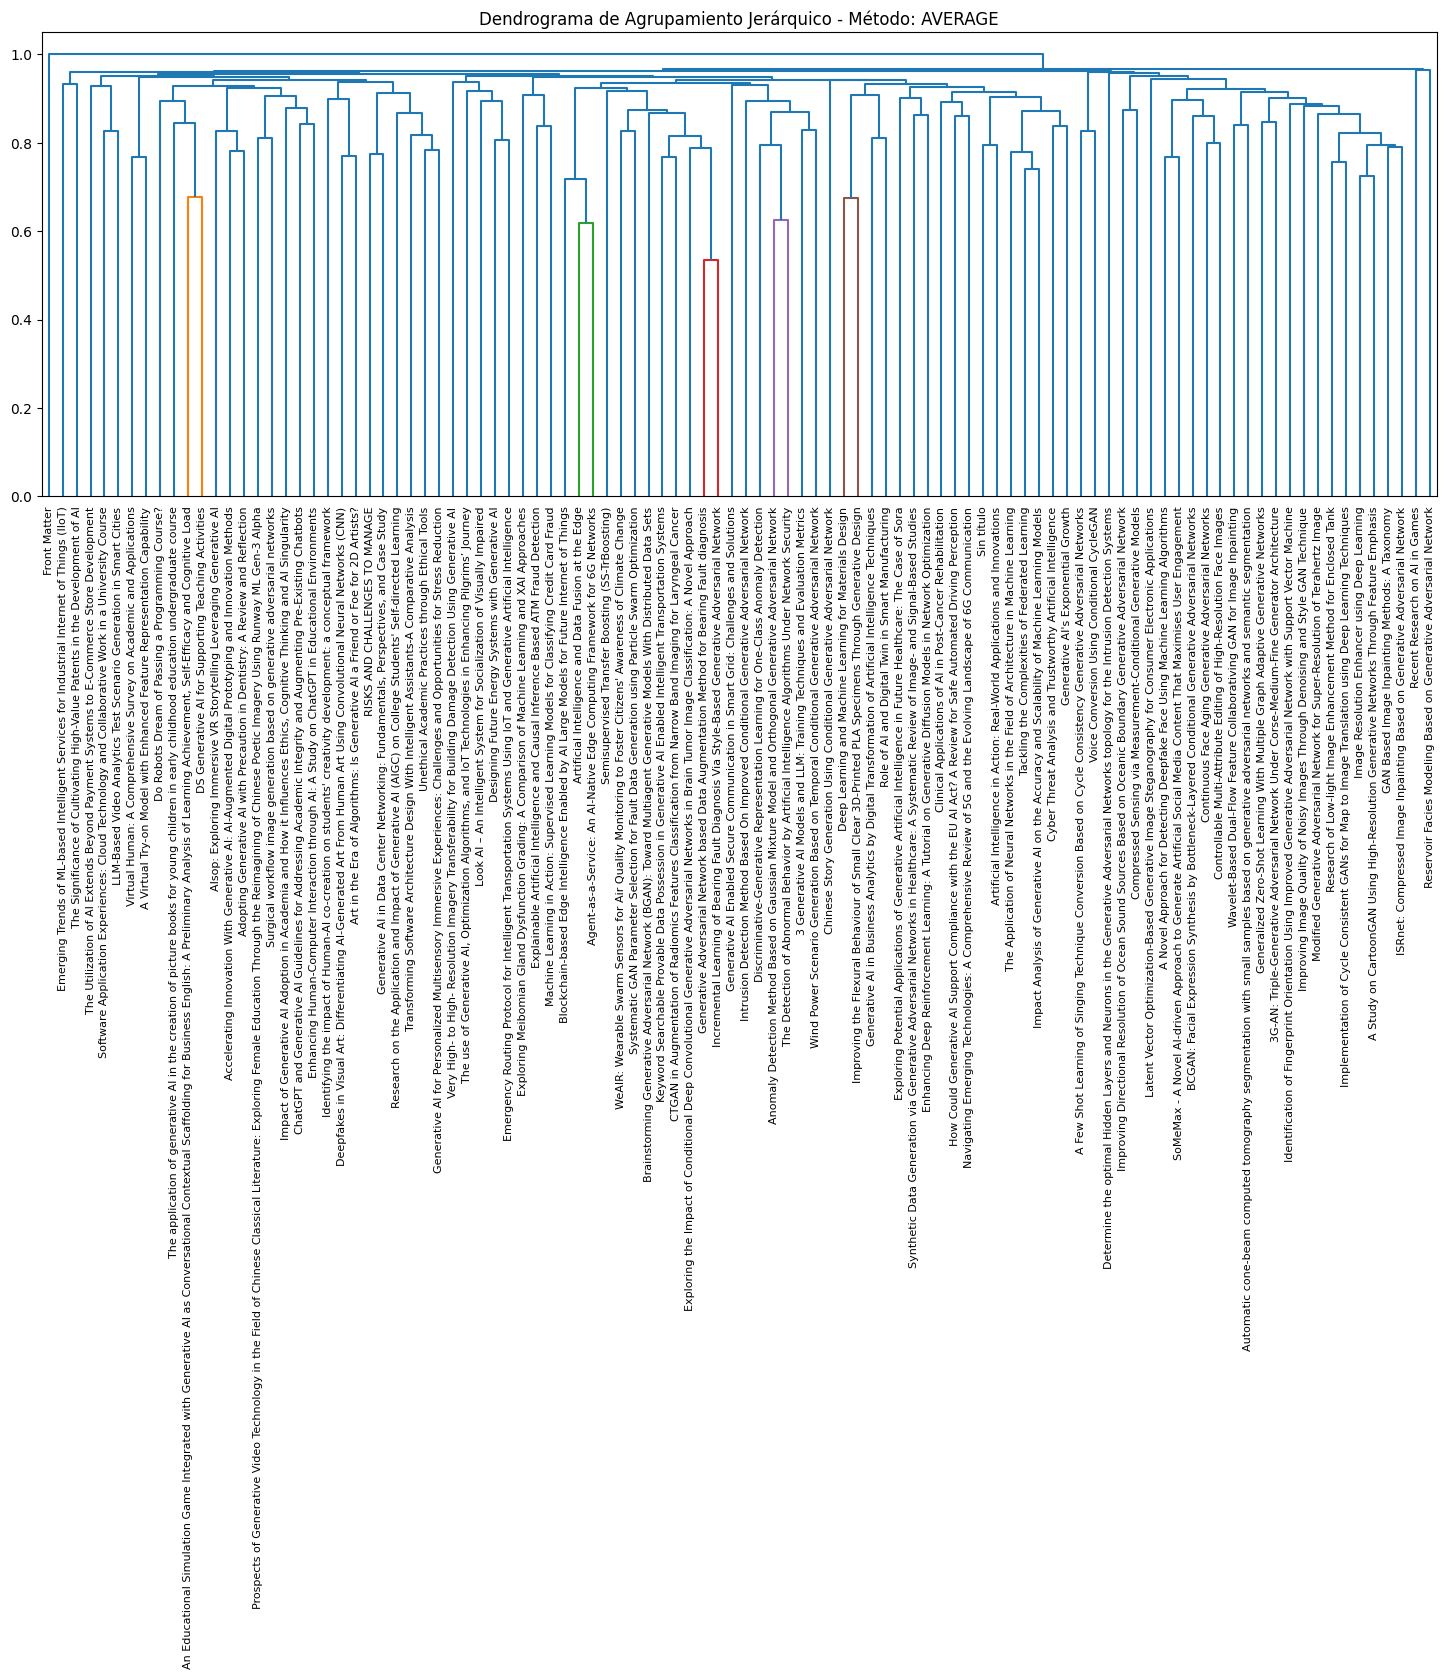

In [11]:
# Estos métodos determinan cómo se calcula la distancia entre grupos de documentos:
# - "single": usa la menor distancia entre dos puntos de diferentes clusters.
# - "complete": usa la mayor distancia entre dos puntos de diferentes clusters.
# - "average": usa el promedio de todas las distancias entre los puntos de los clusters.
metodos = ["single", "complete", "average"]

# Bucle principal para generar un dendrograma por cada método
for metodo in metodos:
    print(f"\nGenerando dendrograma con método: {metodo.upper()}...")

    # Se calcula la distancia entre cada par de abstracts usando la métrica del coseno.
    # La distancia coseno mide cuán similares son dos vectores TF-IDF:
    # - 0 → textos idénticos
    # - 1 → textos completamente diferentes
    dist_matrix = pdist(matriz_tfidf.toarray(), metric="cosine")

    # En algunos casos, la distancia coseno puede devolver valores NaN o infinitos
    # si hay vectores vacíos. np.nan_to_num() reemplaza esos valores por 0.
    dist_matrix = np.nan_to_num(dist_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    # linkage() usa la matriz de distancias para construir la jerarquía de agrupamiento.
    # - 'method' define cómo se unen los clusters (según el método actual del bucle).
    # - El resultado 'Z' es una matriz que describe las fusiones de clusters paso a paso.
    Z = linkage(dist_matrix, method=metodo)

    # Se genera un gráfico jerárquico que muestra la similitud entre los abstracts.
    # Cada "rama" representa un grupo de textos que comparten palabras y contexto similar.
    plt.figure(figsize=(18, 8))
    plt.title(f"Dendrograma de Agrupamiento Jerárquico - Método: {metodo.upper()}")
    dendrogram(Z, labels=titulos_muestra, leaf_rotation=90, leaf_font_size=8)
    
    # Ajustar los márgenes manualmente para que no se corten las etiquetas
    plt.subplots_adjust(bottom=0.3)  # Aumenta el margen inferior
    
    # Guardar el dendrograma como imagen PNG con bbox_inches='tight'
    ruta_guardado = f"dendrograma_{metodo}.png"
    plt.savefig(ruta_guardado, dpi=300, bbox_inches='tight')
    print(f"Dendrograma guardado en: {ruta_guardado}")

    plt.show()

### Clustering Jerárquico - Método de Enlace Completo (Complete Linkage)

### Clustering Jerárquico con Enlace Completo

Esta celda implementa clustering jerárquico usando el método de enlace completo.

#### Fundamento Matemático:

**Enlace Completo (Complete Linkage)**:

La distancia entre dos clusters $C_i$ y $C_j$ se define como:

$$d(C_i, C_j) = \max_{x \in C_i, y \in C_j} d(x, y)$$

Es decir, la distancia máxima entre cualquier par de puntos de los dos clusters.

**Algoritmo**:
1. Inicialmente, cada documento es un cluster
2. En cada iteración:
   - Encuentra el par de clusters con menor distancia máxima
   - Fusiona ese par en un nuevo cluster
3. Repite hasta tener un solo cluster

**Características**:
- **Clusters compactos**: Minimiza el diámetro del cluster
- **Robusto a outliers**: Menos sensible a puntos aislados que enlace simple
- **Clusters esféricos**: Tiende a formar grupos más equilibrados
- **Complejidad**: $O(n^2 \log n)$

#### Implementación:

```python
Z_complete = linkage(X.toarray(), method='complete', metric='euclidean')
```

**Parámetros**:
- `method='complete'`: Usa enlace completo
- `metric='euclidean'`: Distancia euclidiana entre vectores TF-IDF

**Salida**:
- Matriz de enlace `Z` con estructura idéntica a enlace simple
- Las distancias de fusión son generalmente mayores que en enlace simple

#### Visualización con Dendrograma:

```python
dendrogram(Z_complete, truncate_mode='lastp', p=30)
```

**Interpretación**:
- Fusiones a mayor altura indican clusters más dispersos
- Cortes horizontales definen número de clusters
- Comparar con enlace simple revela diferencias en estructura de agrupamiento

### Características del Método Single Linkage

**Ventajas**:
- Detecta relaciones débiles entre artículos
- Útil para identificar transiciones temáticas
- Muestra la cadena de similitud entre documentos

**Desventajas**:
- **Efecto chaining**: Clusters se alargan excesivamente
- Difícil identificar grupos compactos
- Sensible a artículos puente que conectan temas diferentes

**Interpretación**:
- Las fusiones ocurren a alturas muy bajas
- Muchos artículos se unen gradualmente
- Estructura menos clara de grupos temáticos

### Clustering Jerárquico - Método de Enlace Promedio (Average Linkage)

### Clustering Jerárquico con Enlace Promedio

Esta celda implementa clustering jerárquico usando el método de enlace promedio.

#### Fundamento Matemático:

**Enlace Promedio (Average Linkage)**:

La distancia entre dos clusters $C_i$ y $C_j$ se define como:

$$d(C_i, C_j) = \frac{1}{|C_i| \cdot |C_j|} \sum_{x \in C_i} \sum_{y \in C_j} d(x, y)$$

Es decir, el promedio de todas las distancias entre pares de puntos de los dos clusters.

**Algoritmo**:
1. Inicialmente, cada documento es un cluster
2. En cada iteración:
   - Calcula la distancia promedio entre todos los pares de clusters
   - Fusiona el par con menor distancia promedio
3. Repite hasta tener un solo cluster

**Características**:
- **Balance**: Compromiso entre enlace simple y completo
- **Menos sensible a outliers**: Más robusto que enlace simple
- **Clusters equilibrados**: Evita el efecto cadena del enlace simple
- **Complejidad**: $O(n^2 \log n)$

#### Implementación:

```python
Z_average = linkage(X.toarray(), method='average', metric='euclidean')
```

**Parámetros**:
- `method='average'`: Usa enlace promedio
- `metric='euclidean'`: Distancia euclidiana entre vectores TF-IDF

**Salida**:
- Matriz de enlace `Z` con estructura estándar
- Las distancias de fusión representan promedios, típicamente intermedias entre simple y completo

#### Visualización con Dendrograma:

```python
dendrogram(Z_average, truncate_mode='lastp', p=30)
```

**Interpretación**:
- Estructura más balanceada que enlace simple
- Menos extrema que enlace completo
- Útil para identificar clusters naturales en los datos

### Características del Método Average Linkage

El dendrograma del método average linkage presenta una estructura jerárquica más equilibrada, con agrupamientos definidos y alturas intermedias de unión.

**Observaciones**:
- Las ramas están más uniformemente distribuidas
- Mayor estabilidad en las similitudes entre abstracts
- Mejor separación entre grupos grandes
- Evita el encadenamiento del método single
- Evita el sobreajuste del método complete

**Interpretación**:
Average linkage logra una agrupación más coherente y representativa, reflejando relaciones temáticas más naturales entre los textos.

### Comparación de Métodos de Enlace

Esta celda visualiza los tres métodos de enlace simultáneamente para comparación.

#### Objetivo:

Comparar visualmente cómo cada método de enlace estructura los clusters:
- **Enlace Simple**: Tiende a formar cadenas
- **Enlace Completo**: Forma clusters compactos
- **Enlace Promedio**: Balance entre ambos extremos

#### Implementación:

```python
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

dendrogram(Z_single, ax=axes[0], truncate_mode='lastp', p=30)
axes[0].set_title('Enlace Simple')

dendrogram(Z_complete, ax=axes[1], truncate_mode='lastp', p=30)
axes[1].set_title('Enlace Completo')

dendrogram(Z_average, ax=axes[2], truncate_mode='lastp', p=30)
axes[2].set_title('Enlace Promedio')
```

#### Interpretación:

**Comparar**:
- **Alturas de fusión**: Indican cuándo se unen clusters
- **Estructura del árbol**: Forma y balance de los dendrogramas
- **Número de clusters**: Según diferentes cortes horizontales

**Selección del método**:
- Depende de la naturaleza de los datos y el objetivo del análisis
- Enlace promedio suele ser una buena opción por defecto
- Validar con métricas de calidad de clustering

### Método del Codo (Elbow Method) para Determinar Número Óptimo de Clusters